In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


taxon_species_name
Lycorma delicatula     12813
Harmonia axyridis      11352
Apis mellifera          9946
Lymantria dispar        6931
Popillia japonica       3252
Halyomorpha halys       2390
Tenodera sinensis       1845
Vespula germanica       1614
Adelges tsugae           588
Agrilus planipennis      478
Aedes japonicus          114
Name: count, dtype: int64
Total images: 51323
Unique species: 11


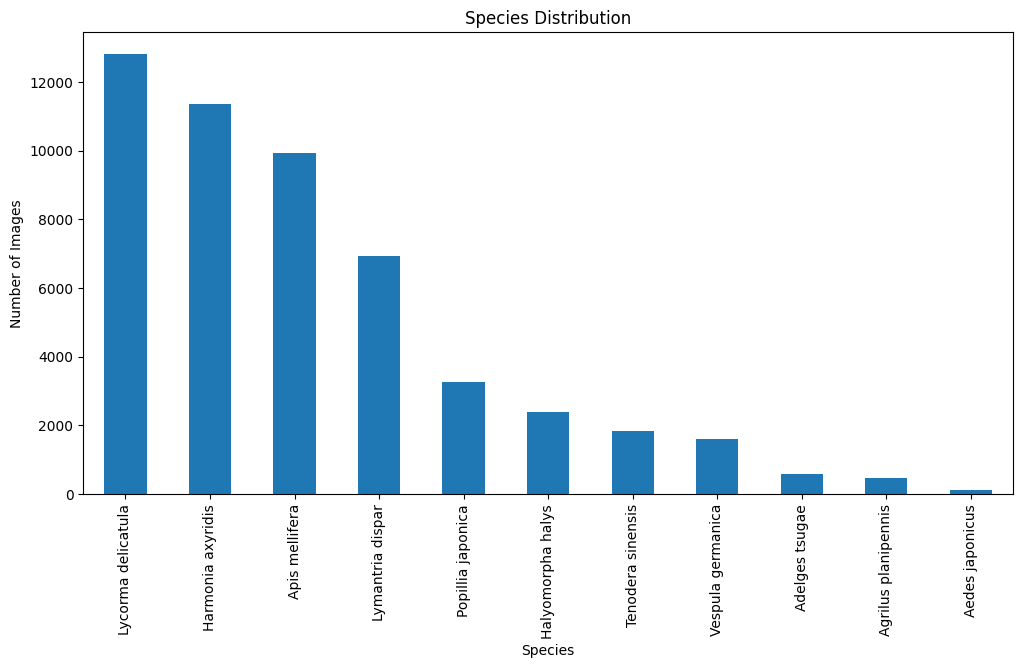

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

metadata_path = '/content/drive/MyDrive/AI4C/Final_Project/metadata.csv'
df = pd.read_csv(metadata_path)

species_counts = df['taxon_species_name'].value_counts()
print(species_counts)

total_images = len(df)
unique_species = df['taxon_species_name'].nunique()
print(f'Total images: {total_images}')
print(f'Unique species: {unique_species}')

species_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Species Distribution')
plt.xlabel('Species')
plt.ylabel('Number of Images')
plt.show()

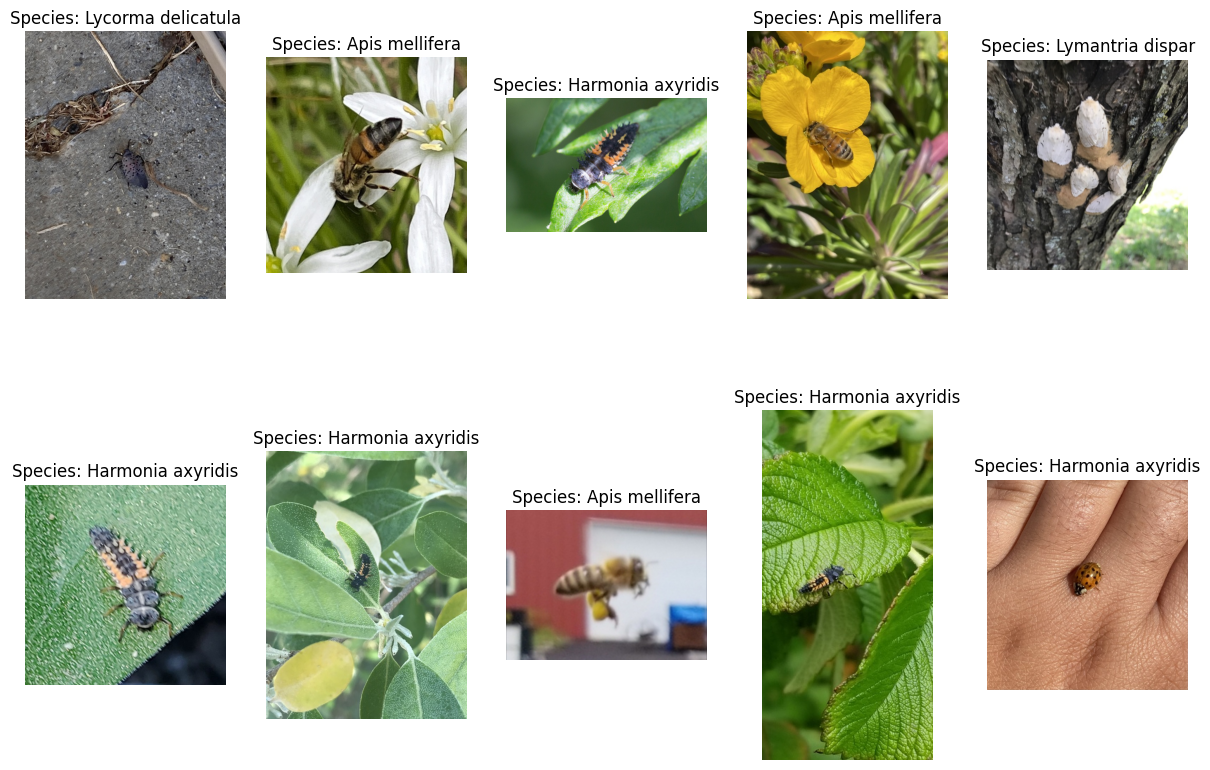

              id  taxon_species_name         common_name
49740  241671682  Lycorma delicatula  Spotted Lanternfly
19727  116468441      Apis mellifera   Western Honey Bee
12924   83990504   Harmonia axyridis   Asian Lady Beetle
41454  204824708      Apis mellifera   Western Honey Bee
464      7028973    Lymantria dispar         Spongy Moth
6666    49896485   Harmonia axyridis   Asian Lady Beetle
11573   80404236   Harmonia axyridis   Asian Lady Beetle
2674    24709717      Apis mellifera   Western Honey Bee
6156    48663822   Harmonia axyridis   Asian Lady Beetle
48760  238259138   Harmonia axyridis   Asian Lady Beetle


In [ ]:
import random
from PIL import Image
import urllib.parse
import os
import requests
from io import BytesIO

sample_images = df.sample(10)

plt.figure(figsize=(15, 10))

for i, row in enumerate(sample_images.itertuples(), 1):
  response = requests.get(row.image_url)
  img = Image.open(BytesIO(response.content))
  plt.subplot(2, 5, i)
  plt.imshow(img)
  plt.title(f'Species: {row.taxon_species_name}')
  plt.axis('off')
plt.show()

print(sample_images[['id', 'taxon_species_name', 'common_name']])

In [ ]:
import pandas as pd

# Load your metadata
metadata_path = '/content/drive/MyDrive/AI4C/Final_Project/metadata.csv'
metadata = pd.read_csv(metadata_path)

# Define the list of target species you want to keep in the dataset
species_list = [
    "Harmonia axyridis", "Lymantria dispar", "Agrilus planipennis",
    "Popillia japonica", "Lycorma delicatula", "Halyomorpha halys",
    "Tenodera sinensis", "Adelges tsugae", "Vespula germanica",
    "Apis mellifera", "Anoplophora glabripennis"
]

# Set the ceiling for the number of images per species
ceiling = 500  # Adjust this number based on your preference

# Filter and sample metadata for each species
limited_metadata = pd.DataFrame()  # Initialize an empty DataFrame to store the sampled data

for species in species_list:
    # Get all rows for the current species
    species_data = metadata[metadata['taxon_species_name'] == species]

    # If the number of images is more than the ceiling, randomly sample the ceiling number
    if len(species_data) > ceiling:
        species_data = species_data.sample(n=ceiling, random_state=42)

    # Append to the limited metadata
    limited_metadata = pd.concat([limited_metadata, species_data])

# Reset index
limited_metadata.reset_index(drop=True, inplace=True)

# Save or use limited_metadata as needed for the CustomLabelClassifier
print("Species distribution after limiting the dataset:")
print(limited_metadata['taxon_species_name'].value_counts())


Species distribution after limiting the dataset:
taxon_species_name
Harmonia axyridis      500
Lymantria dispar       500
Popillia japonica      500
Lycorma delicatula     500
Halyomorpha halys      500
Tenodera sinensis      500
Adelges tsugae         500
Vespula germanica      500
Apis mellifera         500
Agrilus planipennis    478
Name: count, dtype: int64


In [ ]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output

In [ ]:
!pip install pybioclip
clear_output()

In [ ]:
import os
import pandas as pd
from bioclip import CustomLabelsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

image_path = '/content/drive/MyDrive/AI4C/Final_Project/temp_image.jpg'

custom_classifier = CustomLabelsClassifier(species_list)

# Define performance tracking dictionary
performance = {
    "y_true": [],
    "y_pred": []
}

# Function to download and open an image from a URL
def load_image_from_url(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Failed to load image from {url}: {e}")
        return None

# Process each image in the dataset
for _, row in tqdm(limited_metadata.iterrows(), total=len(limited_metadata), desc="Processing Images"):
    image_url = row['image_url']
    ground_truth = row['taxon_species_name']

    # Load image from URL
    image = load_image_from_url(image_url)
    if image is None:
        continue  # Skip if image loading failed

    image = image.convert('RGB')

    # Save image temporarily
    image.save(image_path)

    # Predict using CustomLabelsClassifier
    prediction = custom_classifier.predict(image_path)
    predicted_species = prediction[0]['classification'] if prediction else None
    #print(f"Predicted Species: {predicted_species}")

    # Store predictions and ground truths for metric calculation
    performance["y_true"].append(ground_truth)
    performance["y_pred"].append(predicted_species)

# Calculate and display performance metrics
accuracy = accuracy_score(performance["y_true"], performance["y_pred"]) * 100
precision = precision_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
recall = recall_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100
f1 = f1_score(performance["y_true"], performance["y_pred"], average='weighted', zero_division=1) * 100

print(f"Baseline Performance Metrics with CustomLabelsClassifier:\n"
      f"  Accuracy: {accuracy:.2f}%\n"
      f"  Precision: {precision:.2f}%\n"
      f"  Recall: {recall:.2f}%\n"
      f"  F1 Score: {f1:.2f}%")


Processing Images: 100%|██████████| 4978/4978 [1:41:41<00:00,  1.23s/it]

Baseline Performance Metrics with CustomLabelsClassifier:
  Accuracy: 93.89%
  Precision: 94.35%
  Recall: 93.89%
  F1 Score: 94.08%
